In [4]:
%load_ext autoreload
%autoreload 2
from math import factorial
from skfda.representation.basis import FourierBasis
from skfda.representation.basis import BSplineBasis
from skfda.representation.grid import FDataGrid
import numpy as np

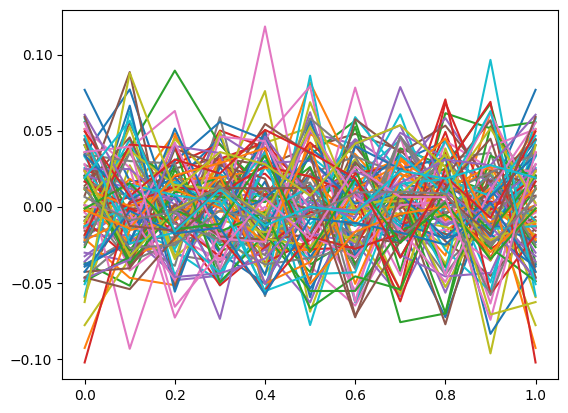

In [6]:
# Build Fourier-related data
num_functions = 100
n_basis_representation = 11
if n_basis_representation % 2 == 0:
    n_basis_representation = n_basis_representation + 1
basis = FourierBasis(n_basis=n_basis_representation)
basis_bsplines = BSplineBasis(n_basis=n_basis_representation)
ini = 0
end = 1
period = 1
domain_range = (ini, end)
step = 0.1
abscissa_points = np.arange(ini, end + step, step)
total_abscissa_points = abscissa_points.shape[0]
row_vector_ones_total_abscissa_points = np.ones(shape=(1, total_abscissa_points))
col_vector_ones_num_functions = np.ones(shape=(num_functions, 1))
X_simulated = np.empty(shape=(num_functions, total_abscissa_points))
basis_evaluated = np.squeeze(basis(abscissa_points))
#lambda_coefficients = np.array([1/(2 ** i) for i in range(1, n_basis_representation + 1)], ndmin=2)
lambda_coefficients = np.array([1 for i in range(1, n_basis_representation + 1)], ndmin=2)
lambda_matrix = np.dot(lambda_coefficients.T, row_vector_ones_total_abscissa_points)
for i in range(num_functions):
    np.random.seed(1234 + i)
    normal_vector = np.random.normal(scale=0.01, size=(1, n_basis_representation))
    normal_matrix = np.dot(normal_vector.T, row_vector_ones_total_abscissa_points)
    # Each basis is multiplied by the same coefficient. Therefore, given a basis (a row), we use
    # the same coefficient for all the columns (time)
    coefficients_basis_matrix = np.multiply(normal_matrix, lambda_matrix)
    basis_with_coefficients_matrix = np.multiply(basis_evaluated, coefficients_basis_matrix)
    sum_basis = np.sum(basis_with_coefficients_matrix, axis=0)
    X_simulated[i, :] = sum_basis
X_simulated_grid = FDataGrid(data_matrix=X_simulated, grid_points=abscissa_points, domain_range=domain_range)
X_basis_fourier = X_simulated_grid.to_basis(basis)
X_basis_bsplines = X_simulated_grid.to_basis(basis_bsplines)
zzz = X_simulated_grid.plot()

In [54]:
class ShapleyFda:
    def __init__(
        self,
        predict_fn,
        X,
        abscissa_points,
        target,
        domain_range,
        verbose,
    ):
        self.predict_fn = predict_fn
        self.X = X
        self.abscissa_points = abscissa_points
        self.target = target
        self.domain_range = domain_range
        self.verbose = verbose

    def validations(self, num_intervals, set_intervals):
        pass

    def print(self, *args):
        if self.verbose:
            str_print = ""
            for arg in args:
                str_print = str_print + " " + str(arg)
            print(str_print)

    def to_numpy(self, obj):
        obj_np = obj
        if isinstance(obj, int) or isinstance(obj, float):
            obj_np = np.array([obj])
        return obj_np

    def compute_function_from_matrix(self, set_abscissa_points, matrix):
        set_abscissa_points = self.to_numpy(set_abscissa_points)
        i_point = 0
        f_points = np.empty(shape=(matrix.shape[0], set_abscissa_points.shape[0]))
        for point in set_abscissa_points:
            if (point < self.domain_range[0] or point > self.domain_range[1]):
                raise ValueError("points contains a point outside the domain range (domain_range)")
            min_position = np.max(np.argwhere(point >= self.abscissa_points))
            num_min = self.abscissa_points[min_position]
            if (np.abs(num_min - point) < 1e-7):
                f_points[:, i_point] = matrix[:, min_position]
            else:
                max_position = np.min(np.argwhere(point < self.abscissa_points))
                num_max = self.abscissa_points[max_position]
                w_min = 1 - (point - num_min)/(num_max - num_min)
                w_max = 1 - (num_max - point)/(num_max - num_min)
                f_min = matrix[:, min_position]
                f_max = matrix[:, max_position]
                f_eval_point = np.add(np.multiply(w_min, f_min), np.multiply(w_max, f_max))
                f_points[:, i_point] = f_eval_point
            i_point += 1
        return f_points

    def compute_f(self, set_abscissa_points):
        return self.compute_function_from_matrix(set_abscissa_points, self.X)

    def create_set_intervals(self, num_intervals, intervals):
        if num_intervals is None and intervals is None:
            raise ValueError("Either num_intervals or intervals must not be None")
        elif num_intervals:
            ini_domain_range = self.domain_range[0]
            end_domain_range = self.domain_range[1]
            long_domain_range = end_domain_range - ini_domain_range
            intervals_lower_bound = np.array(
                [ini_domain_range + i * long_domain_range/num_intervals for i in range(num_intervals)]
            )
            intervals_upper_bound = np.array(
                [ini_domain_range + (i + 1) * long_domain_range/num_intervals for i in range(num_intervals)]
            )
            intervals = np.stack((intervals_lower_bound, intervals_upper_bound), axis=1)
        elif intervals:
            # TODO: if the user provides intervals, standardise it so that
            # it has the same shape as if it were created by the previous statement
            pass
        return intervals

    def create_permutations(self, num_intervals, num_permutations):
        set_permutations = set()
        total_set_permutations = len(set_permutations)
        # Error when impossible number of permutations is desired
        if num_permutations > factorial(num_intervals):
            raise ValueError("num_permutations can no be greater than the factorial of number of intervals")
        # Iterate until the desired number of permutations is obtained
        while total_set_permutations < num_permutations:
            new_permutation = np.random.choice(a=num_intervals, size=num_intervals, replace=False)
            new_permutation = tuple(new_permutation)
            set_permutations.add(new_permutation)
            total_set_permutations = len(set_permutations)
        return set_permutations

    def break_permutation(self, permutation, global_interval_position, use_interval):
        interval_position_inside_permutation = np.argwhere(global_interval_position == permutation).squeeze()
        # Given the permutation, some we will have to interpolate the information for some of the intervals.
        # Depending if the current interval is used or not.
        if use_interval:
            available_intervals = permutation[:(interval_position_inside_permutation + 1)]
            non_available_intervals = permutation[(interval_position_inside_permutation + 1):]
        else:
            available_intervals = permutation[:interval_position_inside_permutation]
            non_available_intervals = permutation[interval_position_inside_permutation:]
        return available_intervals, non_available_intervals

    def map_abscissa_interval(self, set_intervals):
        set_intervals_shape = set_intervals.shape
        map_object = np.full(shape=self.abscissa_points.shape, fill_value=1, dtype=int)
        num_intervals = set_intervals_shape[0]
        last_end_interval = set_intervals[num_intervals-1, 1]
        i_abscissa = 0
        for abscissa in self.abscissa_points:
            if(np.abs(abscissa - last_end_interval) < 1e-7):
                interval_position = num_intervals - 1
            else:
                interval_position = np.ravel(np.argwhere((abscissa >= set_intervals[:, 0]) & (abscissa < set_intervals[:, 1])))
                interval_position = interval_position[0]
            map_object[i_abscissa] = interval_position
            i_abscissa += 1
        return map_object

    def get_abscissa_from_intervals(self, intervals, mapping_abscissa_interval):
        set_abscissa = []
        for interval in intervals:
            abscissa_interval = np.ravel(np.argwhere(interval == mapping_abscissa_interval))
            set_abscissa.extend(abscissa_interval.tolist())
        return np.array(set_abscissa, dtype=np.int64)

    def conditional_expectation(
            self,
            mean_1,
            mean_2,
            matrix_mult
        ):
        def inner_conditional_expectation(x_2):
            diff = np.subtract(x_2, mean_2)
            vector_mult = np.dot(matrix_mult, diff)
            result = np.add(mean_1, vector_mult)
            return result
        return inner_conditional_expectation
        
    def recompute_covariate(
            self,
            mapping_abscissa_interval,
            global_interval_position,
            permutation,
            mean_f,
            covariance_f,
            use_interval
        ):
        recomputed_covariate = np.empty(shape=self.X.shape)
        permutation_array = np.array(permutation)
        # Break the permutation into two parts:
            # first part is the one we are allowed to use
            # second part is the one to be interpolated, i.e, non-available information
        available_intervals, non_available_intervals = self.break_permutation(permutation_array, global_interval_position, use_interval)
        self.print(
            "\t\tuse_interval:", use_interval,
            "available_intervals:", available_intervals, 
            "non_available_intervals:", non_available_intervals
        )
        # For available_intervals, use real values
        position_available_abscissa = self.get_abscissa_from_intervals(available_intervals, mapping_abscissa_interval)
        available_abscissa = self.abscissa_points[position_available_abscissa]
        f_available_abscissa = self.compute_f(available_abscissa)
        recomputed_covariate[:, position_available_abscissa] = f_available_abscissa
        # For non_available_intervals, use the conditional expecation
        position_non_available_abscissa = self.get_abscissa_from_intervals(
            non_available_intervals,
            mapping_abscissa_interval
        )
        non_available_abscissa = self.abscissa_points[position_non_available_abscissa]
        self.print(
            "\t\tavailable_abscissa:",
            available_abscissa,
            "non_available_abscissa",
            non_available_abscissa
        )
        # Get main statistics to compute conditional expetation
        mean_available_abscissa = mean_f[position_available_abscissa]
        mean_non_available_abscissa = mean_f[position_non_available_abscissa]
        covariance_mix = covariance_f[position_non_available_abscissa, :][:, position_available_abscissa]
        covariance_available_abscissa = covariance_f[position_available_abscissa, :][:, position_available_abscissa]
        inv_covariance_available_abscissa = np.linalg.inv(covariance_available_abscissa)
        matrix_mult = np.matmul(covariance_mix, inv_covariance_available_abscissa)
        conditional_expectation_fn = self.conditional_expectation(
            mean_1=mean_non_available_abscissa,
            mean_2=mean_available_abscissa,
            matrix_mult=matrix_mult
        )
        total_individuals = self.X.shape[0]
        for i in range(total_individuals):
            X_i_available_abscissa = np.reshape(
                self.X[i][position_available_abscissa],
                newshape=(-1, 1)
            )
            conditional_expectation_i = np.ravel(conditional_expectation_fn(X_i_available_abscissa))
            recomputed_covariate[i][position_non_available_abscissa] = conditional_expectation_i
        return recomputed_covariate

    def compute_interval_relevance(
            self,
            set_intervals,
            set_permutations,
            mapping_abscissa_interval,
            mean_f,
            covariance_f,
            interval_position
        ):
        set_differences = []
        # For each permutation
        for i_permutation in set_permutations:
            self.print("\tPermutation:", i_permutation)
            # Recreate the set of functions without considering the interval
            covariate_no_interval = self.recompute_covariate(
                mapping_abscissa_interval,
                interval_position,
                i_permutation,
                mean_f,
                covariance_f,
                use_interval = False
            )
             # Recreate the set of functions considering the interval
            covariate_interval = self.recompute_covariate(
                mapping_abscissa_interval,
                interval_position,
                i_permutation,
                mean_f,
                covariance_f,
                use_interval = True
            )
            # Retrain the model without considering the interval and obtain the score
            #score_no_interval = self.obtain_score(covariate_no_interval, self.target)
            #self.print("\t\tscore_no_interval:", score_no_interval)
            # Retrain the model considering the interval and obtain the score
            #score_interval = self.obtain_score(covariate_interval, self.target)
            #self.print("\t\tscore_interval:", score_interval)
            # Compute the differnece of scores
            #diff_score = score_interval - score_no_interval
            #diff_score = score_no_interval - score_interval
            # Stack the difference
            #self.print("\t\tdiff_score:", diff_score)
            #set_differences.append(diff_score)
        # Compute the mean value
        #mean_val = np.mean(set_differences)
        #return mean_val

    def compute_shapley_value(self, num_permutations, num_intervals=None, intervals=None):
        # Create a set of intervals: 
        #       we will treat all the intervals as [a, b), 
        #       except for the las one, which will be [a, b]
        set_intervals = self.create_set_intervals(num_intervals, intervals)
        self.print("set_intervals:\n", set_intervals)
        # Perform validations
        self.validations(num_intervals, set_intervals)
        num_intervals = set_intervals.shape[0] if num_intervals is None else num_intervals
        # Get the set of permutations
        set_permutations = self.create_permutations(num_intervals=num_intervals, num_permutations=num_permutations)
        self.print("set_permutations:", set_permutations)
        # Map each abscissa point with its interval
        mapping_abscissa_interval = self.map_abscissa_interval(set_intervals)
        self.print("abscissa:", self.abscissa_points, " ", "abscissa_interval:", mapping_abscissa_interval)
        # Compute mean value and covariance matrix
        mean_f = np.reshape(np.mean(self.X, axis=0), newshape=(-1, 1))
        covariance_f = np.cov(self.X, rowvar=False, bias=True)
        # For each interval, compute the relevance
        intervals_relevance = []
        for i_interval in range(num_intervals):
            interval = set_intervals[i_interval]
            self.print("Computing relevance for interval:", interval, "whose index is", i_interval)
            relevance = self.compute_interval_relevance(
                set_intervals,
                set_permutations,
                mapping_abscissa_interval,
                mean_f,
                covariance_f,
                i_interval
            )
            #result = [interval, relevance]
            #intervals_relevance.append(result)
        #return intervals_relevance


In [55]:
shapley_fda = ShapleyFda(
    #predict_fn=predict_function,
    predict_fn=1,
    X=X_simulated,
    abscissa_points=abscissa_points,
    target=1,
    domain_range=domain_range,
    verbose=True,
)
values_shapley = shapley_fda.compute_shapley_value(num_intervals=5, num_permutations=1)

 set_intervals:
 [[0.  0.2]
 [0.2 0.4]
 [0.4 0.6]
 [0.6 0.8]
 [0.8 1. ]]
 set_permutations: {(4, 3, 2, 0, 1)}
 abscissa: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]   abscissa_interval: [0 0 1 1 2 2 3 3 4 4 4]
 Computing relevance for interval: [0.  0.2] whose index is 0
 	Permutation: (4, 3, 2, 0, 1)
 		use_interval: False available_intervals: [4 3 2] non_available_intervals: [0 1]
 		available_abscissa: [0.8 0.9 1.  0.6 0.7 0.4 0.5] non_available_abscissa [0.  0.1 0.2 0.3]
 		use_interval: True available_intervals: [4 3 2 0] non_available_intervals: [1]
 		available_abscissa: [0.8 0.9 1.  0.6 0.7 0.4 0.5 0.  0.1] non_available_abscissa [0.2 0.3]
 Computing relevance for interval: [0.2 0.4] whose index is 1
 	Permutation: (4, 3, 2, 0, 1)
 		use_interval: False available_intervals: [4 3 2 0] non_available_intervals: [1]
 		available_abscissa: [0.8 0.9 1.  0.6 0.7 0.4 0.5 0.  0.1] non_available_abscissa [0.2 0.3]
 		use_interval: True available_intervals: [4 3 2 0 1] non_available_int

array([ 0.00063744, -0.00142868, -0.00188171,  0.00012371, -0.00048718,
        0.00068184, -0.00137569,  0.00383339,  0.00267936, -0.00218071,
        0.00063744])